In [ ]:
pip install tinymlgen

Saving voice_dataset.py to voice_dataset.py
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 1,491
Trainable params: 1,491
Non-trainable param

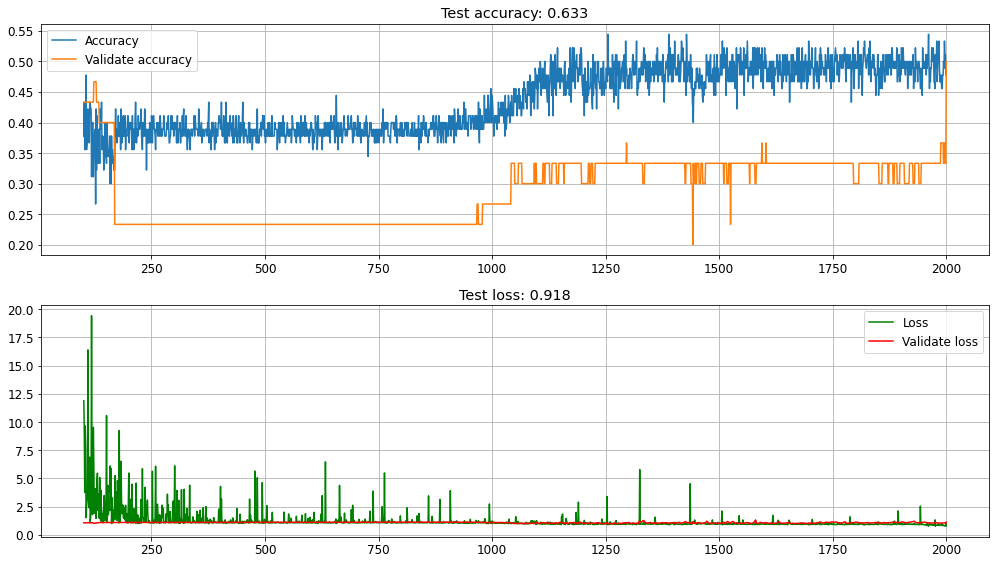

In [ ]:
from google.colab import files


files.upload()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # only print out fatal log

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras import layers, Sequential

tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

RANDOM_SEED = 30
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from voice_dataset import data, target

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=RANDOM_SEED)
data_train, data_validate, target_train, target_validate = train_test_split(
    data_train, target_train, test_size=0.25, random_state=RANDOM_SEED)


model = Sequential()
model.add(layers.Dense(data.shape[1], activation='relu', input_shape=(data.shape[1],)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(np.unique(target).size * 4, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(np.unique(target).size, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



ITERATION = 2000
BATCH_SIZE = 16


history = model.fit(data_train, target_train, epochs=ITERATION, batch_size=BATCH_SIZE,
                    validation_data=(data_validate, target_validate))
predictions = model.predict(data_test)
test_score = model.evaluate(data_test, target_test)


predictions_categorical = np.argmax(predictions, axis=1)

print('Prediction Accuracy:', accuracy_score(target_test, predictions_categorical).round(3))
print('Test accuracy:', round(test_score[1], 3))
print('Test loss:', round(test_score[0], 3))
print('')
print(classification_report(target_test, predictions_categorical))

from tinymlgen import port
with open('tf_lite_model.h', 'w') as f:  # change path if needed
    f.write(port(model, optimize=False))


DISPLAY_SKIP = 100

import matplotlib.pyplot as plt


accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = np.arange(len(accuracy)) + 1

plt.rcParams['font.size'] = 12
plt.figure(figsize=(14, 8))

plt.subplot(211)
plt.title(f'Test accuracy: {round(test_score[1], 3)}')
plt.plot(epochs[DISPLAY_SKIP:], accuracy[DISPLAY_SKIP:], label='Accuracy')
plt.plot(epochs[DISPLAY_SKIP:], val_accuracy[DISPLAY_SKIP:], label='Validate accuracy')
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.title(f'Test loss: {round(test_score[0], 3)}')
plt.plot(epochs[DISPLAY_SKIP:], loss[DISPLAY_SKIP:], label='Loss', color='green')
plt.plot(epochs[DISPLAY_SKIP:], val_loss[DISPLAY_SKIP:], label='Validate loss', color='red')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()